Dataset is available here: https://ai.stanford.edu/~jkrause/cars/car_dataset.html

Data set has around 16k images (8k for training & 8k for testing)
Can split take 2k images for validation

The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

Citation:
3D Object Representations for Fine-Grained Categorization
Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei
4th IEEE Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.

In [ ]:
""" imports """
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import scipy.io                               # required to read the .mat files
import torchvision                                      # for importing dataset
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import json

import os
import random
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

home_path = '/content/gdrive/My Drive/3rd Year/2nd Semester/APS360/APS360 Project/Code/Data/'


os.chdir(home_path)
!pwd

Mounted at /content/gdrive/
/content/gdrive/My Drive/3rd Year/2nd Semester/APS360/APS360 Project/Code/Data


# Part A: Data cleaning & setup

## Information about dataset
- The given dataset contains the following files:
  
  1. cars_meta.mat: contains all 196 original labels
  2. cars_train_annos.mat: Contains the variable 'annotations', which is a struct array of length num_images and where each element has the fields
  3. cars_test_annos.mat: Same format as 'cars_train_annos.mat', except the class is not provided.

- However, this project does not need the 196 labels, but instead cares about only the brand name. Thus, the labels will have to be adjusted as a first step.

## File name: 'cars_meta.mat'

### Description: Contains all 196 original labels

This is stored in a particular format (which we'll see soon enough). The goal is to extract all the 196 classes into a data structure which will be modified into the adjusted classes.

In [ ]:
file = scipy.io.loadmat('cars_meta.mat')

In [ ]:
print(file)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013', '__version__': '1.0', '__globals__': [], 'class_names': array([[array(['AM General Hummer SUV 2000'], dtype='<U26'),
        array(['Acura RL Sedan 2012'], dtype='<U19'),
        array(['Acura TL Sedan 2012'], dtype='<U19'),
        array(['Acura TL Type-S 2008'], dtype='<U20'),
        array(['Acura TSX Sedan 2012'], dtype='<U20'),
        array(['Acura Integra Type R 2001'], dtype='<U25'),
        array(['Acura ZDX Hatchback 2012'], dtype='<U24'),
        array(['Aston Martin V8 Vantage Convertible 2012'], dtype='<U40'),
        array(['Aston Martin V8 Vantage Coupe 2012'], dtype='<U34'),
        array(['Aston Martin Virage Convertible 2012'], dtype='<U36'),
        array(['Aston Martin Virage Coupe 2012'], dtype='<U30'),
        array(['Audi RS 4 Convertible 2008'], dtype='<U26'),
        array(['Audi A5 Coupe 2012'], dtype='<U18'),
        array(['Audi TTS Coupe 2012'], dtype='<U19'),
  

In [ ]:
print(type(file['class_names']))
classes = file['class_names'][0]

<class 'numpy.ndarray'>


In [ ]:
def split_string_categories(input):
  """
  - example:
  - input: 'Bentley Arnage Sedan 2009'
  - output: 'Bentley', 'Arnage Sedan', '2009'
  """
  split_string = input.split()
  separator = ' '
  brand_name = split_string[0]
  year = split_string[-1]
  model_name = separator.join(split_string[1:(len(split_string)-1)])

  return brand_name, model_name, year

In [ ]:
print("There are", len(classes), "number of classes in the dataset")

def data_clean(classes):
  """
  - Returns 3 data structures:
  1. adjusted_classes: Dictonary that maps the brand name to the adjusted class
  2. brand_names: Dictonary that maps the adjusted class to the brand name
  3. original_classes: array that maps original classes to adjusted
  """
  adjusted_class_number = 1 # starts from 0
  # data structs to store relevant data
  adjusted_classes = {} # from brand name to adjusted class number
  brand_names = {} # from adjusted class number to brand name
  # need a dictionary of lists that map new class to original class
  original_classes = [] # from original class to adjusted class number
  original_classes.append(-1) # there is no class 0 so add a null value

  for c in classes:

    brand_name, model_name, year = split_string_categories(c[0])

    if brand_name not in adjusted_classes.keys():
      adjusted_classes[brand_name] = adjusted_class_number
      brand_names[adjusted_class_number] = brand_name

      original_classes.append(adjusted_class_number)
      adjusted_class_number += 1

    else:
      original_classes.append(adjusted_classes[brand_name])

  print(adjusted_classes)
  print(brand_names)
  print(original_classes)
  return adjusted_classes, brand_names, original_classes

There are 196 number of classes in the dataset


In [ ]:
adjust_classes, brand_names, original_classes = data_clean(classes)
print("Adjusted class (defined as unique brand) number is:",len(adjust_classes))

{'AM': 1, 'Acura': 2, 'Aston': 3, 'Audi': 4, 'BMW': 5, 'Bentley': 6, 'Bugatti': 7, 'Buick': 8, 'Cadillac': 9, 'Chevrolet': 10, 'Chrysler': 11, 'Daewoo': 12, 'Dodge': 13, 'Eagle': 14, 'FIAT': 15, 'Ferrari': 16, 'Fisker': 17, 'Ford': 18, 'GMC': 19, 'Geo': 20, 'HUMMER': 21, 'Honda': 22, 'Hyundai': 23, 'Infiniti': 24, 'Isuzu': 25, 'Jaguar': 26, 'Jeep': 27, 'Lamborghini': 28, 'Land': 29, 'Lincoln': 30, 'MINI': 31, 'Maybach': 32, 'Mazda': 33, 'McLaren': 34, 'Mercedes-Benz': 35, 'Mitsubishi': 36, 'Nissan': 37, 'Plymouth': 38, 'Porsche': 39, 'Ram': 40, 'Rolls-Royce': 41, 'Scion': 42, 'Spyker': 43, 'Suzuki': 44, 'Tesla': 45, 'Toyota': 46, 'Volkswagen': 47, 'Volvo': 48, 'smart': 49}
{1: 'AM', 2: 'Acura', 3: 'Aston', 4: 'Audi', 5: 'BMW', 6: 'Bentley', 7: 'Bugatti', 8: 'Buick', 9: 'Cadillac', 10: 'Chevrolet', 11: 'Chrysler', 12: 'Daewoo', 13: 'Dodge', 14: 'Eagle', 15: 'FIAT', 16: 'Ferrari', 17: 'Fisker', 18: 'Ford', 19: 'GMC', 20: 'Geo', 21: 'HUMMER', 22: 'Honda', 23: 'Hyundai', 24: 'Infiniti', 25

In [ ]:
def get_adjusted_from_original(original_class_no):
  """
  - Given the original class number, return the adjusted class number & brand name
  - Example: input: 196
  - Outputs: (49, smart)
  """
  adjusted_class_no = original_classes[original_class_no]
  if adjusted_class_no == -1:
    print("Error! Incorrect original class no.")
    return adjusted_class_no, "DNE"
  return adjusted_class_no, brand_names[adjusted_class_no]


In [ ]:
original_class = 196
adjusted_class, brand_name = get_adjusted_from_original(original_class)
print("Original class:",
      original_class,
      ". Adjusted class:",
      adjusted_class,
      ". Brand (class) name is:",
      brand_name)

Original class: 196 . Adjusted class: 49 . Brand (class) name is: smart


In [ ]:
def get_brand_name_from_adjusted_class(adjusted_class_no):
  """
  - Given the adjusted class number return the brand name
  - Example: input: 49
  - Output: smart
  """
  return brand_names[adjusted_class_no]

In [ ]:
def get_adjusted_label(labels):
  """
  - Given the original labels (tensors that takes values from 1 to 196)
  - (i.e. original labels), return a tensor with the adjusted labels (values
  from 1 to 49).
  """
  actual_label = []
  for i in range(len(labels)):
    adjusted_class, brand_name = get_adjusted_from_original(labels[i].item()+1)
    # different from data structs
    actual_label.append(adjusted_class)
  adjusted_label = torch.tensor(actual_label)
  return adjusted_label

In [ ]:
def showPictures(data_loader, size=3):
  # plot the images in the batch, along with the corresponding labels
  dataiter = iter(data_loader)
  images,labels = dataiter.next()
  labels = get_adjusted_label(labels) # important step!!!!! similar to normalizing
  # print(labels)
  images = images.numpy() # convert images to numpy for display
  for i in range(size): ## size pictures of the batch
    plt.figure()
    plt.imshow(np.transpose(images[i], (1, 2, 0)), cmap='gray')
    # plt.imshow(images[i], cmap='gray')
    # plt.imshow((out * 255).astype(np.uint8))
    plt.title(get_brand_name_from_adjusted_class(labels[i].item()))

In [ ]:
path = home_path + 'car_data/'

train_path = path + 'train/'
test_path = path + 'test/'

print(train_path)
print(test_path)

train_transforms = transforms.Compose([transforms.Resize((244,244)),
                                       transforms.RandomHorizontalFlip(), #flipping a car does not change the brand
                                       transforms.RandomRotation(30), #rotate to reduce noise
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #grayscale

val_test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.CenterCrop(224),
                                      # transforms.Grayscale(num_output_channels=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_data = torchvision.datasets.ImageFolder(train_path, transform=train_transforms)
test_data = torchvision.datasets.ImageFolder(test_path, transform=val_test_transforms)

lengths = [int(len(test_data)*0.2)+1, int(len(test_data)*0.8)]

val_data, test_data = torch.utils.data.random_split(test_data, lengths)


train_data_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=4)
test_data_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=4)

val_data_loader = torch.utils.data.DataLoader(val_data,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=4)

/content/gdrive/My Drive/APS360 Project/Code/Data/car_data/train/
/content/gdrive/My Drive/APS360 Project/Code/Data/car_data/test/


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


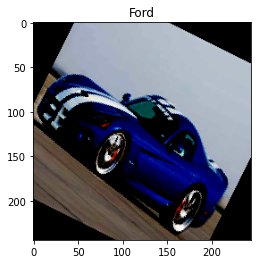

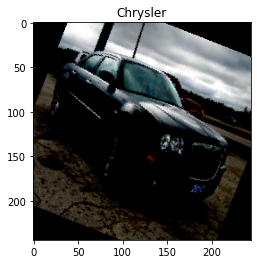

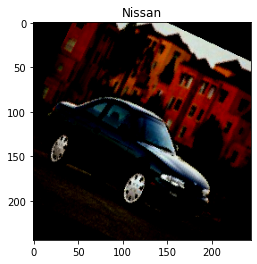

In [ ]:
showPictures(train_data_loader)
# plot the images in the batch, along with the corresponding labels

## Statistics about current data:

  1. Determine the number of elements in each class: This indicates that the number of samples in each class is not consistent. So must duplicate samples so that each class contains the same number of samples as the most frequent class, or compromise efficiency and ceil it to a reasonable number.
  2. Find mean, standard deviation, max & min values and see if the distribution is ideal.

In [ ]:
def get_classes_count(dataset):
  counts = {}
  for _, labels in iter(dataset):
    # print("original labels are:",labels)
    labels = get_adjusted_label(labels) # important step!!!!! similar to normalizing
    # print("adjusted labels are:",labels)
    for label in labels:
      if label.item() not in counts.keys():
        # print("New key added with key #",label.item())
        counts[label.item()] = 1
      else:
        counts[label.item()] += 1
  return counts

In [ ]:
train_counts = get_classes_count(train_data_loader)

In [ ]:
train_counts = get_classes_count(train_data_loader)
val_counts = get_classes_count(val_data_loader)
test_counts = get_classes_count(test_data_loader)

In [ ]:
print(val_counts)

In [ ]:
def get_x_y_data(counts):
  total = 0
  x_axis = []
  y_axis = []
  j = 0
  for i in sorted (counts):
    x_axis.append(i)
    y_axis.append(counts[i])
    if j == 16:
      # print("\n")
      j = 0
    # print ((i, counts[i]), end = " ")
    j+=1
    total += counts[i]
  print("Total items:",total)
  return x_axis, y_axis

In [ ]:
def plot_data_counts(x_axis, y_axis):
  plt.figure()
  plt.scatter(x_axis, y_axis)
  plt.title("Data count by class")

In [ ]:
def analyze_data(counts):
  x, y = get_x_y_data(counts)
  plot_data_counts(x, y)
  y_np = np.array(y)
  print("Max count of class occurence is:", y_np.max())
  print("Min count of class occurence is:", y_np.min())
  print("Avg count of class occurence is:", y_np.mean())
  print("Std var of class occurence is:", y_np.std())

In [ ]:
def print_counts(counts):
  x, y = get_x_y_data(counts)
  print()
  for i in range(len(x)):
    print("Brand Name:",
          get_brand_name_from_adjusted_class(i+1),
          " has count:",
          y[i])

In [ ]:
print("Train data analysis")
analyze_data(train_counts)

In [ ]:
"""
Must remove images with high counts (> 400)
BMW: 531
Audi: 589
Chevrolet: 905
Dodge: 630
Ford: 521
Hyundai: 438
"""

In [ ]:
print("Val data analysis")
analyze_data(val_counts)

In [ ]:
print("Testing data analysis")
analyze_data(test_counts)

#Part B: Baseline Model

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from PIL import Image
from numpy import asarray
import skimage
import skimage.io
from skimage.transform import resize
from sklearn.svm import LinearSVC

from PIL import Image

from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

In [ ]:
def load_image_files(container_path):
  flat_data = []
  target = []

  for i in range(len(train_data_loader.dataset.imgs)):
    img = skimage.io.imread(train_data_loader.dataset.imgs[i][0])
    img_resized = resize(img, (244,244), anti_aliasing=True, mode='reflect')
    check = get_adjusted_from_original(train_data_loader.dataset.imgs[i][1]+1)
    arr = np.array(img_resized)
    if len(arr.shape) > 2:
      arr = arr[:, :, 0]*0.299 + arr[:, :, 1]*0.587 + arr[:, :, 2]*0.114
    flat_data.append(arr.flatten())
    target.append(check[0])
    if i % 500 == 0:
      print(i)

  for i in range(len(test_data_loader.dataset.dataset.imgs)):
    img = skimage.io.imread(test_data_loader.dataset.dataset.imgs[i][0])
    img_resized = resize(img, (244,244), anti_aliasing=True, mode='reflect')
    check = get_adjusted_from_original(test_data_loader.dataset.dataset.imgs[i][1]+1)
    arr = np.array(img_resized)
    if len(arr.shape) > 2:
      arr = arr[:, :, 0]*0.299 + arr[:, :, 1]*0.587 + arr[:, :, 2]*0.114
    flat_data.append(arr.flatten())
    target.append(check[0])
    if i % 500 == 0:
      print(i)


  flat_data = np.array(flat_data)
  target = np.array(target)
  return Bunch(data=flat_data,
            target=target)

In [ ]:
image_dataset = load_image_files(train_path)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset.data, image_dataset.target, test_size=0.3)

print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

In [ ]:
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)
print(grid.best_params_)

In [ ]:
model = grid.best_estimator_
y_pred = model.predict(X_test)

In [ ]:
print("Classification report for - \n{}:\n{}\n".format(
    grid, metrics.classification_report(y_test, y_pred)))

#Part C: Primary Model

In [ ]:
# With more convulation and pooling layers
class CarModelDetector(nn.Module):
    def __init__(self):
        super(CarModelDetector, self).__init__()
        # in_channels = input image channels
        # out_channels = conv filters outputs/feature maps
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.conv3 = nn.Conv2d(10, 20, 5)

        self.fc1 = nn.Linear(20 * 24 * 24, 2 * 24 * 24)
        self.fc2 = nn.Linear(2 * 24 * 24, 50)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        # Feature map size = 220 (input image 224 x 224)
        # Feature map size after pooling = 110
        x = self.pool(F.relu(self.conv2(x)))
        # Feature map size = 106
        # Feature map size after pooling = 53
        x = self.pool(F.relu(self.conv3(x)))
        # Feature map size = 49
        # Feature map size after pooling = 24
        x = x.view(-1, 20 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
def train(model, train_loader, val_loader, batch_size=32, num_epochs=1, learn_rate = 0.001):
    use_cuda = True
    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    train_acc, val_acc, iters = [], [], []

    # training
    print ("Training Started...")
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            labels = get_adjusted_label(labels)
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            out = model(imgs)             # forward pass
            #if epoch == 0:
              #print("Dimension of label is:", len(labels))
              #print("Dimension of output is:",len(out))
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            iters.append(n)
            n += 1

        # track accuracy
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, val_loader))
        print(epoch, train_acc[-1], val_acc[-1])

    plt.title("Training Curve for Primary Model- batch_size=512, num_epochs=10, learn_rate = 0.0001")

    plt.plot(range(1, len(train_acc)+1), train_acc, label="Train")
    plt.plot(range(1, len(train_acc)+1), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()



    return train_acc, val_acc

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        labels = get_adjusted_label(labels)
        use_cuda = True
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
CarModel = CarModelDetector()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  CarModel.cuda()

Training Started...
0 0.11382313258923096 0.10966542750929369
1 0.13418373604808045 0.11400247831474597
2 0.3355819943579051 0.1251548946716233
3 0.8515883723782657 0.1171003717472119
4 0.9910462406476144 0.10161090458488228
5 0.9973016067705139 0.12143742255266418
6 0.9986508033852569 0.11028500619578686
7 0.9844229118116031 0.1047087980173482
8 1.0 0.1090458488228005
9 1.0 0.1171003717472119


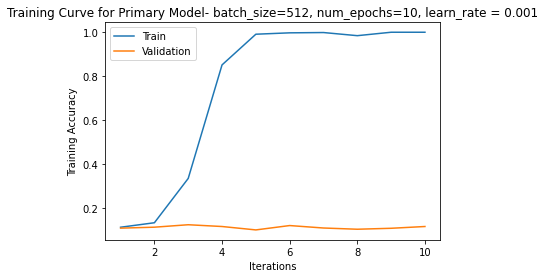

([0.11382313258923096,
  0.13418373604808045,
  0.3355819943579051,
  0.8515883723782657,
  0.9910462406476144,
  0.9973016067705139,
  0.9986508033852569,
  0.9844229118116031,
  1.0,
  1.0],
 [0.10966542750929369,
  0.11400247831474597,
  0.1251548946716233,
  0.1171003717472119,
  0.10161090458488228,
  0.12143742255266418,
  0.11028500619578686,
  0.1047087980173482,
  0.1090458488228005,
  0.1171003717472119])

In [ ]:
train(CarModel, train_data_loader, val_data_loader, batch_size=512, num_epochs=10, learn_rate = 0.001)

Training Started...
0 0.11100208512204096 0.1047087980173482
1 0.11100208512204096 0.1047087980173482
2 0.11100208512204096 0.1047087980173482
3 0.11100208512204096 0.1047087980173482
4 0.11100208512204096 0.1047087980173482
5 0.11100208512204096 0.1047087980173482
6 0.11100208512204096 0.1047087980173482
7 0.11100208512204096 0.1047087980173482
8 0.11100208512204096 0.1047087980173482
9 0.11100208512204096 0.1047087980173482


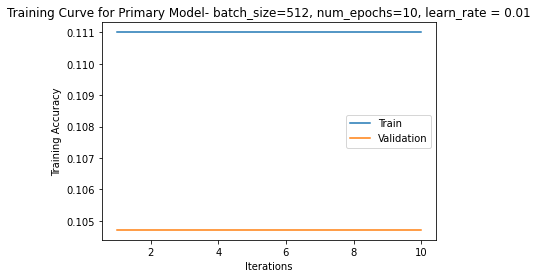

([0.11100208512204096,
  0.11100208512204096,
  0.11100208512204096,
  0.11100208512204096,
  0.11100208512204096,
  0.11100208512204096,
  0.11100208512204096,
  0.11100208512204096,
  0.11100208512204096,
  0.11100208512204096],
 [0.1047087980173482,
  0.1047087980173482,
  0.1047087980173482,
  0.1047087980173482,
  0.1047087980173482,
  0.1047087980173482,
  0.1047087980173482,
  0.1047087980173482,
  0.1047087980173482,
  0.1047087980173482])

In [ ]:
CarModel = CarModelDetector()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  CarModel.cuda()


train(CarModel, train_data_loader, val_data_loader, batch_size=512, num_epochs=10, learn_rate = 0.01)


Training Started...
0 0.11137004783515271 0.1047087980173482
1 0.13025880044155524 0.12143742255266418
2 0.14399607506439346 0.12391573729863693
3 0.1633754446216117 0.12205700123915737
4 0.20053967864589722 0.12825278810408922
5 0.22703299398994234 0.1171003717472119
6 0.3127683061449773 0.12205700123915737
7 0.35778241138231326 0.12329615861214374
8 0.5221390899055562 0.12763320941759604
9 0.6852692260517601 0.12391573729863693


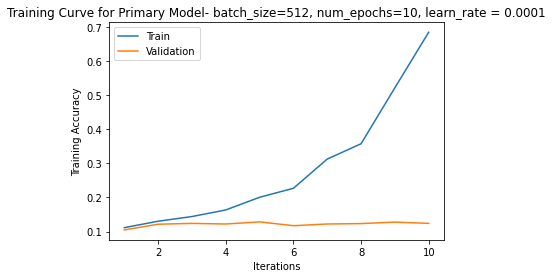

([0.11137004783515271,
  0.13025880044155524,
  0.14399607506439346,
  0.1633754446216117,
  0.20053967864589722,
  0.22703299398994234,
  0.3127683061449773,
  0.35778241138231326,
  0.5221390899055562,
  0.6852692260517601],
 [0.1047087980173482,
  0.12143742255266418,
  0.12391573729863693,
  0.12205700123915737,
  0.12825278810408922,
  0.1171003717472119,
  0.12205700123915737,
  0.12329615861214374,
  0.12763320941759604,
  0.12391573729863693])

In [ ]:
CarModel = CarModelDetector()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  CarModel.cuda()


train(CarModel, train_data_loader, val_data_loader, batch_size=512, num_epochs=10, learn_rate = 0.0001)

In [ ]:
valid_honda = torch.utils.data.DataLoader(
    [e for e in val_data.dataset if original_classes[e[1]+1] == 13],
    val_data.fields)
# Create a Dataset of only non-spam validation examples
valid_hyundai = torch.utils.data.DataLoader(
    [e for e in val_data.dataset if original_classes[e[1]+1] == 10],
    val_data.fields)


# **RESNET MODEL:**


In [ ]:
def evaluate(model, val_loader, criterion):
    valid_loss = 0
    accuracy = 0

    # change model to work with cuda
    model.to('cuda')

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(val_loader):

        # Change images and labels to work with cuda
        labels = get_adjusted_label(labels)
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)

        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return valid_loss, accuracy

In [ ]:
def train_res_net(model, train_loader, val_loader, batch_size=32, num_epochs=10, learn_rate = 0.01):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9)
  lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

  # use_cuda = True
  torch.manual_seed(1000)

  steps = 0
  print_every = 40

  train_loss, train_acc, val_loss, val_acc, iters = [], [], [], [], []
  # change to gpu mode
  model.to('cuda')
  model.train()

  for e in range(num_epochs):

      running_loss = 0
      running_correct = 0
      running_total = 0

      # Iterating over data to carry out training step
      for ii, (images, labels) in enumerate(train_loader):
          steps += 1
          labels = get_adjusted_label(labels)
          images, labels = images.to('cuda'), labels.to('cuda')

          # zeroing parameter gradients
          optimizer.zero_grad()

          # Forward and backward passes
          outputs = model.forward(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          # track accuracy:
          pred = outputs.max(1, keepdim=True)[1]
          running_correct += pred.eq(labels.view_as(pred)).sum().item()
          running_total += images.shape[0]

      iters.append(e)
      valid_loss, val_accuracy = evaluate(model, val_loader, criterion)

      train_acc.append(running_correct/running_total)
      val_acc.append(val_accuracy/len(val_loader))

      train_loss.append(running_loss/running_total)
      val_loss.append(valid_loss/len(val_loader))

      lrscheduler.step(val_accuracy * 100)
      print("Epoch:",e+1,
            ". Training Accuracy is:", train_acc[-1],
            ". Validation Accuracy is:", val_acc[-1])

  print("Training done. Time to plot results!")
  return iters, val_loss, val_acc, train_acc, train_loss


In [ ]:
def plot_results(x, training, validation, title):
  plt.figure()
  plt.plot(x, training, label='training')
  plt.plot(x, validation, label='validation')
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel(title)
  plt.legend(loc='best')

In [ ]:
pretrained_model = models.resnet34(pretrained=True)

Epoch: 1 . Training Accuracy is: 0.321599411259659 . Validation Accuracy is: tensor(0.4535)
Epoch: 2 . Training Accuracy is: 0.5671531951428922 . Validation Accuracy is: tensor(0.6050)
Epoch: 3 . Training Accuracy is: 0.676928737887894 . Validation Accuracy is: tensor(0.6719)
Epoch: 4 . Training Accuracy is: 0.7522384398380964 . Validation Accuracy is: tensor(0.7231)
Epoch: 5 . Training Accuracy is: 0.8062063044278179 . Validation Accuracy is: tensor(0.7427)
Epoch: 6 . Training Accuracy is: 0.9091132098614008 . Validation Accuracy is: tensor(0.8436)
Epoch: 7 . Training Accuracy is: 0.9459094811725746 . Validation Accuracy is: tensor(0.8449)
Epoch: 8 . Training Accuracy is: 0.9587881761314854 . Validation Accuracy is: tensor(0.8566)
Epoch: 9 . Training Accuracy is: 0.9639396541150497 . Validation Accuracy is: tensor(0.8536)
Epoch: 10 . Training Accuracy is: 0.9714215626149884 . Validation Accuracy is: tensor(0.8559)
Training done. Time to plot results!


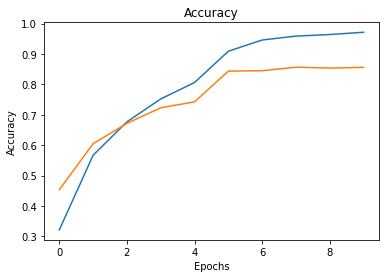

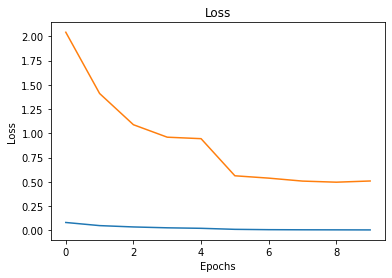

In [ ]:
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 50)

iters, val_loss, val_acc, train_acc, train_loss = train_res_net(
    pretrained_model,
    train_data_loader,
    val_data_loader)

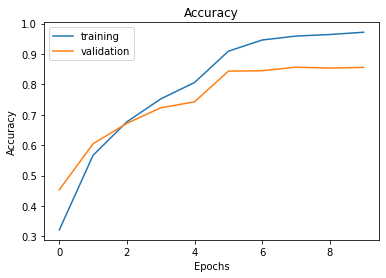

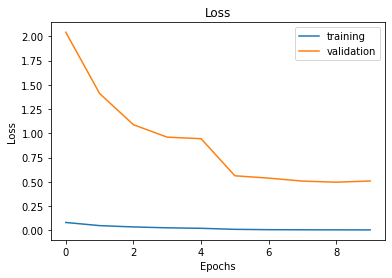

In [ ]:
plot_results(iters, train_acc, val_acc, "Accuracy")
plot_results(iters, train_loss, val_loss, "Loss")

In [ ]:
pretrained_model2 = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
num_features = pretrained_model2.fc.in_features
pretrained_model2.fc = nn.Linear(num_features, 50)

iters2, val_loss2, val_acc2, train_acc2, train_loss2 = train_res_net(
    pretrained_model2,
    train_data_loader,
    val_data_loader, batch_size = 512, num_epochs = 10, learn_rate = 0.001)

Epoch: 1 . Training Accuracy is: 0.20679504476879676 . Validation Accuracy is: tensor(0.3270)
Epoch: 2 . Training Accuracy is: 0.45075432356187906 . Validation Accuracy is: tensor(0.5151)
Epoch: 3 . Training Accuracy is: 0.5964675579541273 . Validation Accuracy is: tensor(0.6097)
Epoch: 4 . Training Accuracy is: 0.7071016803630565 . Validation Accuracy is: tensor(0.6761)
Epoch: 5 . Training Accuracy is: 0.7820434196001472 . Validation Accuracy is: tensor(0.7166)
Epoch: 6 . Training Accuracy is: 0.8394456028455783 . Validation Accuracy is: tensor(0.7504)
Epoch: 7 . Training Accuracy is: 0.8756286029682325 . Validation Accuracy is: tensor(0.7781)
Epoch: 8 . Training Accuracy is: 0.9091132098614008 . Validation Accuracy is: tensor(0.7985)
Epoch: 9 . Training Accuracy is: 0.9379369557218202 . Validation Accuracy is: tensor(0.8130)
Epoch: 10 . Training Accuracy is: 0.9514289218692505 . Validation Accuracy is: tensor(0.8152)
Training done. Time to plot results!


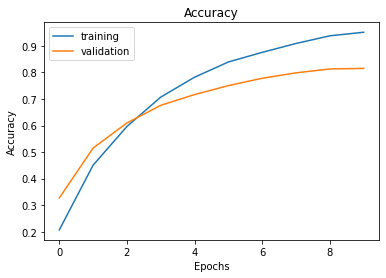

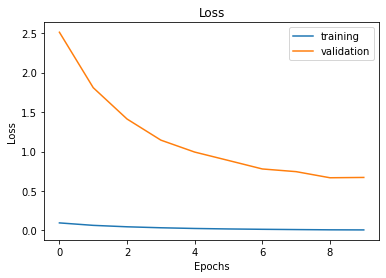

In [ ]:
plot_results(iters2, train_acc2, val_acc2, "Accuracy")
plot_results(iters2, train_loss2, val_loss2, "Loss")

In [ ]:
#This resnet has 50 layers
pretrained_model3 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Epoch: 1 . Training Accuracy is: 0.16864957684287993 . Validation Accuracy is: tensor(0.2807)
Epoch: 2 . Training Accuracy is: 0.39838096406230833 . Validation Accuracy is: tensor(0.4829)
Epoch: 3 . Training Accuracy is: 0.5659266527658531 . Validation Accuracy is: tensor(0.5950)
Epoch: 4 . Training Accuracy is: 0.6801177480681958 . Validation Accuracy is: tensor(0.6886)
Epoch: 5 . Training Accuracy is: 0.7697779958297559 . Validation Accuracy is: tensor(0.7350)
Epoch: 6 . Training Accuracy is: 0.832944928247271 . Validation Accuracy is: tensor(0.7607)
Epoch: 7 . Training Accuracy is: 0.8795535385747577 . Validation Accuracy is: tensor(0.8022)
Epoch: 8 . Training Accuracy is: 0.9292285048448424 . Validation Accuracy is: tensor(0.8075)
Epoch: 9 . Training Accuracy is: 0.9385502269103397 . Validation Accuracy is: tensor(0.8305)
Epoch: 10 . Training Accuracy is: 0.9464000981233902 . Validation Accuracy is: tensor(0.8226)
Training done. Time to plot results!



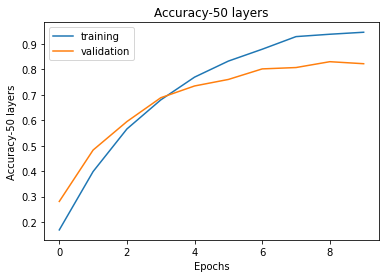

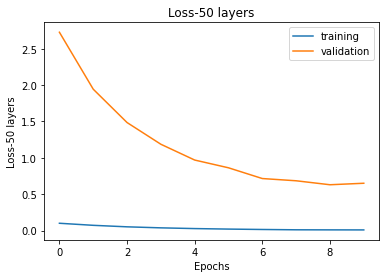

In [ ]:
num_features = pretrained_model3.fc.in_features
pretrained_model3.fc = nn.Linear(num_features, 50)

iters3, val_loss3, val_acc3, train_acc3, train_loss3 = train_res_net(
    pretrained_model3,
    train_data_loader,
    val_data_loader, batch_size = 128, num_epochs = 10, learn_rate = 0.001)

print("")
plot_results(iters3, train_acc3, val_acc3, "Accuracy-50 layers")
plot_results(iters3, train_loss3, val_loss3, "Loss-50 layers")

In [ ]:
pretrained_model4 = models.resnet50(pretrained=True)

Epoch: 1 . Training Accuracy is: 0.35103642830859805 . Validation Accuracy is: tensor(0.5215)
Epoch: 2 . Training Accuracy is: 0.5703422053231939 . Validation Accuracy is: tensor(0.6194)
Epoch: 3 . Training Accuracy is: 0.6668710903961732 . Validation Accuracy is: tensor(0.6957)
Epoch: 4 . Training Accuracy is: 0.7464736906660125 . Validation Accuracy is: tensor(0.7184)
Epoch: 5 . Training Accuracy is: 0.7954127315098737 . Validation Accuracy is: tensor(0.7576)
Epoch: 6 . Training Accuracy is: 0.9083772844351773 . Validation Accuracy is: tensor(0.8495)
Epoch: 7 . Training Accuracy is: 0.9499570710168036 . Validation Accuracy is: tensor(0.8616)
Epoch: 8 . Training Accuracy is: 0.9584202134183736 . Validation Accuracy is: tensor(0.8641)
Epoch: 9 . Training Accuracy is: 0.9641849625904575 . Validation Accuracy is: tensor(0.8704)
Epoch: 10 . Training Accuracy is: 0.9731387219428431 . Validation Accuracy is: tensor(0.8728)
Training done. Time to plot results!



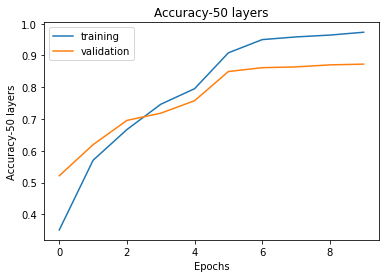

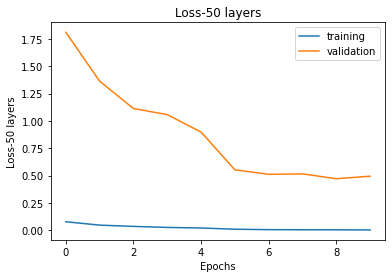

In [ ]:
num_features = pretrained_model4.fc.in_features
pretrained_model4.fc = nn.Linear(num_features, 50)

iters4, val_loss4, val_acc4, train_acc4, train_loss4 = train_res_net(
    pretrained_model4,
    train_data_loader,
    val_data_loader)

print("")
plot_results(iters4, train_acc4, val_acc4, "Accuracy-50 layers")
plot_results(iters4, train_loss4, val_loss4, "Loss-50 layers")

In [ ]:
pretrained_model5 = models.resnet50(pretrained=True)

Epoch: 1 . Training Accuracy is: 0.16987611921991905 . Validation Accuracy is: tensor(0.2841)
Epoch: 2 . Training Accuracy is: 0.40733472341469396 . Validation Accuracy is: tensor(0.4972)
Epoch: 3 . Training Accuracy is: 0.5703422053231939 . Validation Accuracy is: tensor(0.5999)
Epoch: 4 . Training Accuracy is: 0.6896847786091009 . Validation Accuracy is: tensor(0.6850)
Epoch: 5 . Training Accuracy is: 0.7776278670428063 . Validation Accuracy is: tensor(0.7265)
Epoch: 6 . Training Accuracy is: 0.8394456028455783 . Validation Accuracy is: tensor(0.7708)
Epoch: 7 . Training Accuracy is: 0.8843370538452103 . Validation Accuracy is: tensor(0.8083)
Epoch: 8 . Training Accuracy is: 0.9299644302710659 . Validation Accuracy is: tensor(0.8179)
Epoch: 9 . Training Accuracy is: 0.938182264197228 . Validation Accuracy is: tensor(0.8367)
Epoch: 10 . Training Accuracy is: 0.9441923218447197 . Validation Accuracy is: tensor(0.8332)
Training done. Time to plot results!



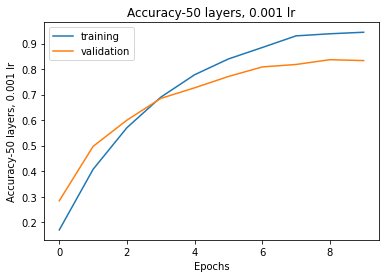

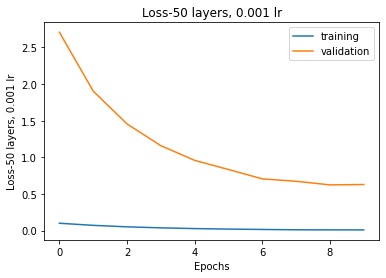

In [ ]:
num_features = pretrained_model5.fc.in_features
pretrained_model5.fc = nn.Linear(num_features, 50)

iters5, val_loss5, val_acc5, train_acc5, train_loss5 = train_res_net(
    pretrained_model5,
    train_data_loader,
    val_data_loader, batch_size = 64, learn_rate = 0.001)

print("")
plot_results(iters5, train_acc5, val_acc5, "Accuracy-50 layers, 0.001 lr")
plot_results(iters5, train_loss5, val_loss5, "Loss-50 layers, 0.001 lr")

In [ ]:
selftrained_model = models.resnet34(pretrained=False)

Epoch: 1 . Training Accuracy is: 0.05675318961724593 . Validation Accuracy is: tensor(0.0597)
Epoch: 2 . Training Accuracy is: 0.06848511511951899 . Validation Accuracy is: tensor(0.0546)
Epoch: 3 . Training Accuracy is: 0.0774307083150022 . Validation Accuracy is: tensor(0.0669)
Epoch: 4 . Training Accuracy is: 0.08417656547880921 . Validation Accuracy is: tensor(0.0719)
Epoch: 5 . Training Accuracy is: 0.0872561959231559 . Validation Accuracy is: tensor(0.0735)
Epoch: 6 . Training Accuracy is: 0.10661387300190643 . Validation Accuracy is: tensor(0.0960)
Epoch: 7 . Training Accuracy is: 0.11159994134037249 . Validation Accuracy is: tensor(0.0946)
Epoch: 8 . Training Accuracy is: 0.1117465904091509 . Validation Accuracy is: tensor(0.0988)
Epoch: 9 . Training Accuracy is: 0.11409297550960551 . Validation Accuracy is: tensor(0.0953)
Epoch: 10 . Training Accuracy is: 0.11805250036662267 . Validation Accuracy is: tensor(0.0983)
Training done. Time to plot results!



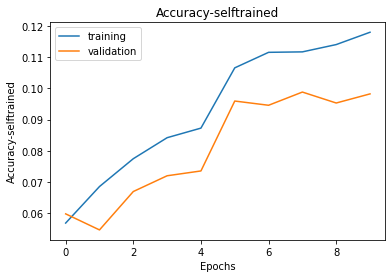

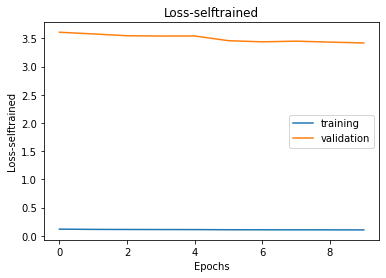

In [ ]:
num_features = selftrained_model.fc.in_features
selftrained_model.fc = nn.Linear(num_features, 50)

iters, val_loss, val_acc, train_acc, train_loss = train_res_net(
    selftrained_model,
    train_data_loader,
    val_data_loader)

print("")
plot_results(iters, train_acc, val_acc, "Accuracy-selftrained")
plot_results(iters, train_loss, val_loss, "Loss-selftrained")

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        labels = get_adjusted_label(labels)
        use_cuda = True
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
print("Test accuracy is:",get_accuracy(pretrained_model, test_data_loader))

Test accuracy is: 0.8683191324554609


## Visualize results

In [ ]:
def store_model(name, model):
  # store the current model
  save_model_directory = home_path + 'models/'
  os.chdir(save_model_directory)
  torch.save(model.state_dict(), name)
  os.chdir(home_path)

In [ ]:
store_model("pretrained_model_epochs10_lr0.01_bs32", pretrained_model)

/content/gdrive/My Drive/3rd Year/2nd Semester/APS360/APS360 Project/Code/Data/models


In [ ]:
store_model("pretrained_model_50layers_epochs10_lr0.01_bs32", pretrained_model4) #Model4. It had slightly higher validation accuracy.

In [ ]:
def load_model(name):
  # load model
  save_model_directory = home_path + 'models/'
  os.chdir(save_model_directory)

  final_model = models.resnet34(pretrained=True)
  num_features = final_model.fc.in_features
  final_model.fc = nn.Linear(num_features, 50)

  state = torch.load(name)
  final_model.load_state_dict(state)

  os.chdir(home_path)
  return final_model

In [ ]:
final_model= load_model("pretrained_model_epochs10_lr0.01_bs32")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
print(final_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def open_image(test_image_path, folder='test/'):
  """
  - Sample input: 'Audi 100 Sedan 1994'
  """
  original_path = os.path.abspath(os.getcwd()) #save current directory
  overall_path = path + folder + test_image_path #contains several images that
  # of type passed in as the argument
  os.chdir(overall_path)

  image_nos = os.listdir(overall_path) #all files containing pngs
   # just take a random one
  image_index = random.choice(image_nos)
  PIL_img = Image.open(image_index)

  transform = transforms.Compose([transforms.Resize((244,244)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(
                                      (0.5, 0.5, 0.5),
                                      (0.5, 0.5, 0.5))
                                  ])
  img = transform(PIL_img)
  numpy_img = np.array(img)
  #going back to original direction
  os.chdir(original_path)

  image = numpy_img.transpose((1, 2, 0))

  # Undo preprocessing
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  image = std * image + mean

  # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
  image = np.clip(image, 0, 1)

  plt.figure()
  # plt.title(test_image_path)
  plt.imshow(image)
  return torch.from_numpy(numpy_img).type(torch.FloatTensor)

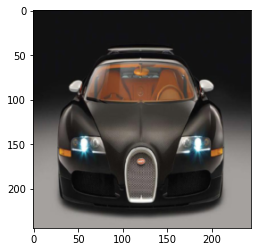

In [ ]:
tensor_imp = open_image('Bugatti Veyron 16.4 Coupe 2009')

In [ ]:
def predict_image(model, car_model, top_elements=3):
  model.eval()
  print("Opening image of model")
  tensor_img = open_image(car_model)

  print("Top " + str(top_elements) + " brands")

  tensor_img_adjust = tensor_img.unsqueeze(0)
  output = model(tensor_img_adjust)
  classification = get_brand_name_from_adjusted_class(output[0].argmax().item())
  top_items = output[0].sort(descending=True)
  for i in range(top_elements):
    print(str(i+1) + ": " + get_brand_name_from_adjusted_class(top_items[1][i].item()))

  plt.title(classification)
  plt.show()

Opening image of model
Top 3 brands
1: Bugatti
2: Lamborghini
3: Bentley


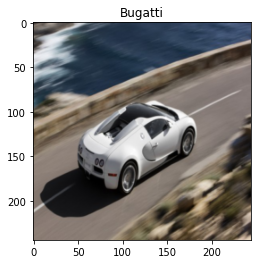

Opening image of model
Top 3 brands
1: Bentley
2: Spyker
3: FIAT


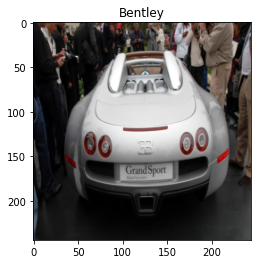

Opening image of model
Top 3 brands
1: Bugatti
2: MINI
3: Maybach


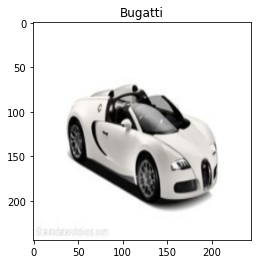

In [ ]:
items_count = 3
for i in range(items_count):
  predict_image(final_model, 'Bugatti Veyron 16.4 Convertible 2009')

Opening image of model
Top 3 brands
1: Ferrari
2: Fisker
3: McLaren


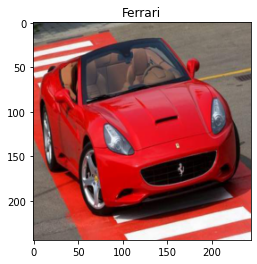

Opening image of model
Top 3 brands
1: Ferrari
2: Chevrolet
3: Dodge


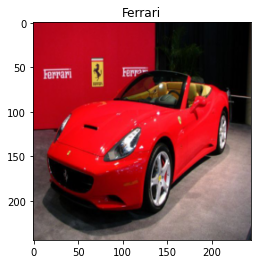

Opening image of model
Top 3 brands
1: Ferrari
2: McLaren
3: Aston


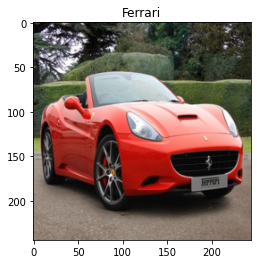

In [ ]:
for i in range(items_count):
  predict_image(final_model, 'Ferrari California Convertible 2012')

Opening image of model
Top 3 brands
1: BMW
2: Mitsubishi
3: Volvo


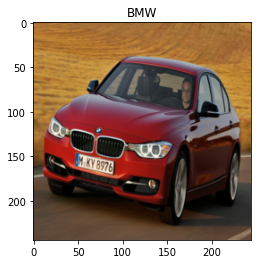

Opening image of model
Top 3 brands
1: BMW
2: Daewoo
3: Chevrolet


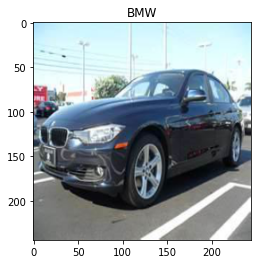

Opening image of model
Top 3 brands
1: BMW
2: Daewoo
3: Volvo


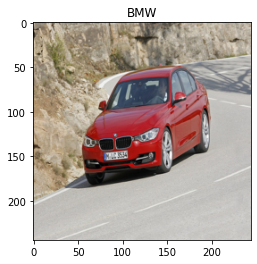

In [ ]:
for i in range(items_count):
  predict_image(final_model, 'BMW 3 Series Sedan 2012')

Opening image of model
Top 3 brands
1: smart
2: Ford
3: MINI


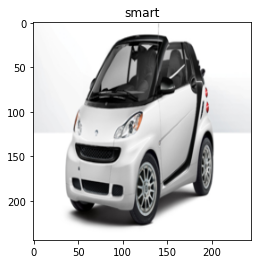

Opening image of model
Top 3 brands
1: smart
2: Chrysler
3: MINI


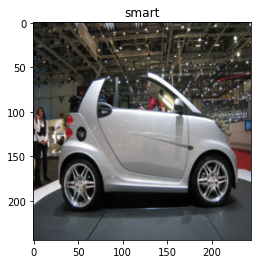

Opening image of model
Top 3 brands
1: smart
2: Ford
3: Suzuki


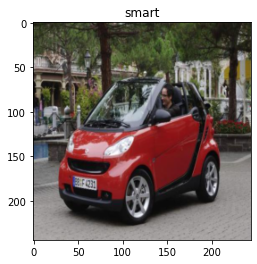

In [ ]:
for i in range(items_count):
  predict_image(final_model, 'smart fortwo Convertible 2012')

Opening image of model
Top 3 brands
1: Chevrolet
2: Suzuki
3: Dodge


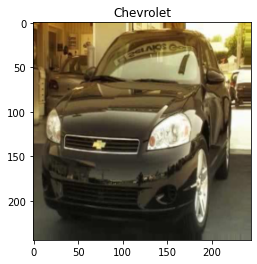

Opening image of model
Top 3 brands
1: Chevrolet
2: Ford
3: Dodge


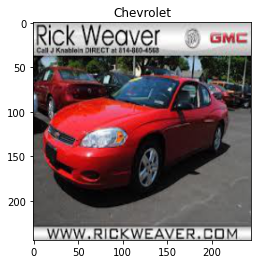

Opening image of model
Top 3 brands
1: Chevrolet
2: Ford
3: Nissan


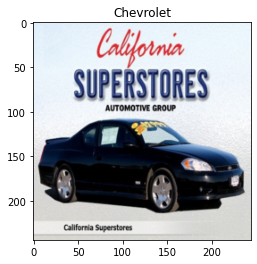

In [ ]:
for i in range(items_count):
  predict_image(final_model, 'Chevrolet Monte Carlo Coupe 2007')

Opening image of model
1: Mercedes-Benz
2: Hyundai
3: Audi


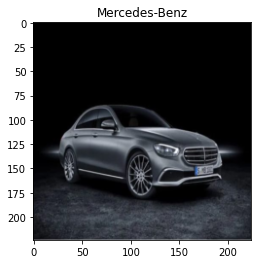

Opening image of model
1: Mercedes-Benz
2: Dodge
3: Audi


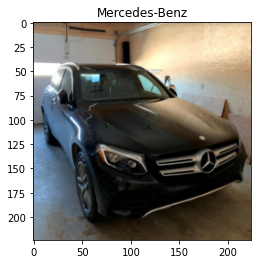

Opening image of model
1: GMC
2: Toyota
3: Mazda


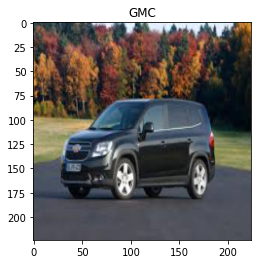

Opening image of model
1: Hyundai
2: Ford
3: Nissan


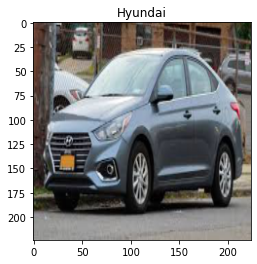

Opening image of model
1: Toyota
2: Acura
3: Chevrolet


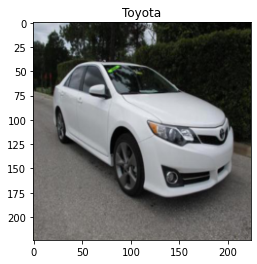

Opening image of model
1: Hyundai
2: Honda
3: Toyota


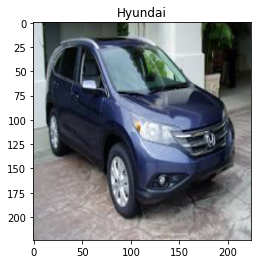

RuntimeError: ignored

In [ ]:
"""
- Sample input: 'Audi 100 Sedan 1994'
"""
original_path = os.path.abspath(os.getcwd()) #save current directory
overall_path = home_path + '/car_data/random_pics/'
os.chdir(overall_path)
image_nos = os.listdir(overall_path) #all files containing pngs
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5),
                                    (0.5, 0.5, 0.5))
                                ])
for i in range(len(image_nos)):
  image_index = image_nos[i]
  PIL_img = Image.open(image_index)
  img = transform(PIL_img)
  numpy_img = np.array(img)
  image = numpy_img.transpose((1, 2, 0))
  # Undo preprocessing
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  image = std * image + mean
  # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
  image = np.clip(image, 0, 1)
  plt.figure()
  # plt.title(test_image_path)
  plt.imshow(image)
  tensor_img = torch.from_numpy(numpy_img).type(torch.FloatTensor)
  final_model.eval()
  print("Opening image of model")
  tensor_img_adjust = tensor_img.unsqueeze(0)
  output = final_model(tensor_img_adjust)
  classification = get_brand_name_from_adjusted_class(output[0].argmax().item())
  top_items = output[0].sort(descending=True)
  for i in range(3):
    print(str(i+1) + ": " + get_brand_name_from_adjusted_class(top_items[1][i].item()))

  plt.title(classification)
  plt.show()

#going back to original direction
os.chdir(original_path)